In this notebook we:
 1) do file conversions to generate .vtk files in order to generate more plots
 2) plot the loss from the training data

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import vtk
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime

ModuleNotFoundError: No module named 'vtk'

**CUDA**

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

*txt to csv*

In [ ]:
input_folder = "data/concentrations_txt/S8"
output_folder = "data/concentrations/S8"

# create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# iterate through files in input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        try:
            # construct input and output file paths
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, os.path.splitext(filename)[0] + ".csv")

            # read txt file and remove leading and trailing quotation marks from each line
            with open(input_filepath, 'r') as file:
                lines = [line.strip().strip('"') for line in file.readlines()]

            # convert to df and save as csv
            df = pd.DataFrame([line.split(',') for line in lines])
            df.to_csv(output_filepath, index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=' ')
            print(f"Converted {input_filepath} to {output_filepath}")
        except Exception as e:
            print(f"Error converting {input_filepath}: {e}")


*csv to vtk for plotting*

In [6]:
pip install vtk

   ---------------------------------------- 0.0/52.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/52.8 MB 653.6 kB/s eta 0:01:21
   ---------------------------------------- 0.2/52.8 MB 2.3 MB/s eta 0:00:23
   ---------------------------------------- 0.5/52.8 MB 4.1 MB/s eta 0:00:13
    --------------------------------------- 0.8/52.8 MB 4.4 MB/s eta 0:00:12
   - -------------------------------------- 1.4/52.8 MB 5.8 MB/s eta 0:00:09
   - -------------------------------------- 2.0/52.8 MB 7.1 MB/s eta 0:00:08
   - -------------------------------------- 2.6/52.8 MB 7.9 MB/s eta 0:00:07
   -- ------------------------------------- 3.2/52.8 MB 8.6 MB/s eta 0:00:06
   -- ------------------------------------- 3.8/52.8 MB 9.1 MB/s eta 0:00:06
   --- ------------------------------------ 4.4/52.8 MB 9.4 MB/s eta 0:00:06
   --- ------------------------------------ 5.0/52.8 MB 9.7 MB/s eta 0:00:05
   ---- ----------------------------------- 5.6/52.8 MB 10.0 MB/s eta 0:00:05
   


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import pandas as pd
import vtk
import os

def csv_to_vtk_per_timestep(csv_file, output_dir):
    try:
        df = pd.read_csv(csv_file)

        required_columns = ['timestep', 'X', 'Y']
        if not all(column in df.columns for column in required_columns):
            raise ValueError(f"CSV file must contain columns: {', '.join(required_columns)}")

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        timesteps = df['timestep'].unique()
        feature_names = [col for col in df.columns if col not in ['timestep', 'X', 'Y']]

        for timestep in timesteps:
            timestep_df = df[df['timestep'] == timestep]

            # Create VTK StructuredPoints object
            structured_points = vtk.vtkStructuredPoints()
            structured_points.SetDimensions(250, 250, 1)  # adjust
            structured_points.SetSpacing(1, 1, 1)
            structured_points.SetOrigin(0, 0, 0)

            # Add point data
            point_data = structured_points.GetPointData()
            for feature in feature_names:
                feature_array = vtk.vtkFloatArray()
                feature_array.SetName(feature)
                feature_array.SetNumberOfComponents(1)
                feature_array.SetNumberOfTuples(250 * 250)  # adjust

                for index, value in enumerate(timestep_df[feature]):
                    feature_array.SetValue(index, value)

                point_data.AddArray(feature_array)

            # Write the data to a VTK file
            vtk_file_path = os.path.join(output_dir, f"timestep_{timestep}.vtk")
            writer = vtk.vtkStructuredPointsWriter()
            writer.SetFileName(vtk_file_path)
            writer.SetInputData(structured_points)
            writer.Write()
            print(f"Successfully wrote {vtk_file_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

csv_file_path = "C:/Users/Giannis/Desktop/neural_agent_models_data/predictions/PINN(250x250)(72-100).csv"
output_dir = "C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)"
csv_to_vtk_per_timestep(csv_file_path, output_dir)

Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_72.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_73.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_74.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_75.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_76.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_77.vtk
Successfully wrote C:/Users/Giannis/Desktop/neural_agent_models_data/vtk_outputs/vtk_outputs(250x250)/vtk_outputs(PINN 72-100)\timestep_78.vtk

*we use next 2 cells to merge data from separate model runs*

In [53]:
def filter_timesteps(csv_file, output_file, max_timestep=10):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)

        # Filter out rows with timestep >= max_timestep
        filtered_df = df[df['timestep'] < max_timestep]

        # Save the filtered DataFrame to a new CSV file
        filtered_df.to_csv(output_file, index=False)
        print(f"Successfully wrote filtered data to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

csv_file_path = "C:/Users/Giannis/Desktop/neural_agent_models_data/predictions/PINN(250x250)(72-89hrs).csv"
output_file_path = "C:/Users/Giannis/Documents/neural-agent-models-main/data/filtered_data.csv"
filter_timesteps(csv_file_path, output_file_path)

Successfully wrote filtered data to C:/Users/Giannis/Documents/neural-agent-models-main/data/filtered_data.csv


In [54]:
def merge_and_rename_timesteps(filtered_file, new_file, output_file):

    try:
    
        df_filtered = pd.read_csv(filtered_file)
        df_new = pd.read_csv(new_file)

        
        df_filtered['timestep'] = df_filtered['timestep'] + 72
        df_new['timestep'] = df_new['timestep'] + 82

        merged_df = pd.concat([df_filtered, df_new], ignore_index=True)

      
        merged_df.to_csv(output_file, index=False)
        print(f"Successfully wrote merged data to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

filtered_file_path = "C:/Users/Giannis/Documents/neural-agent-models-main/data/filtered_data.csv"
new_file_path = "C:/Users/Giannis/Desktop/neural_agent_models_data/predictions/PINN(250x250)(82-100hrs).csv"
output_file_path = "C:/Users/Giannis/Desktop/neural_agent_models_data/predictions/PINN(250x250)(72-100).csv"
merge_and_rename_timesteps(filtered_file_path, new_file_path, output_file_path)

Successfully wrote merged data to C:/Users/Giannis/Desktop/neural_agent_models_data/predictions/PINN(250x250)(72-100).csv


*Plot loss curves together from training data*

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_3244\2266034810.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_color('#505050')  # A grey color for the ticks


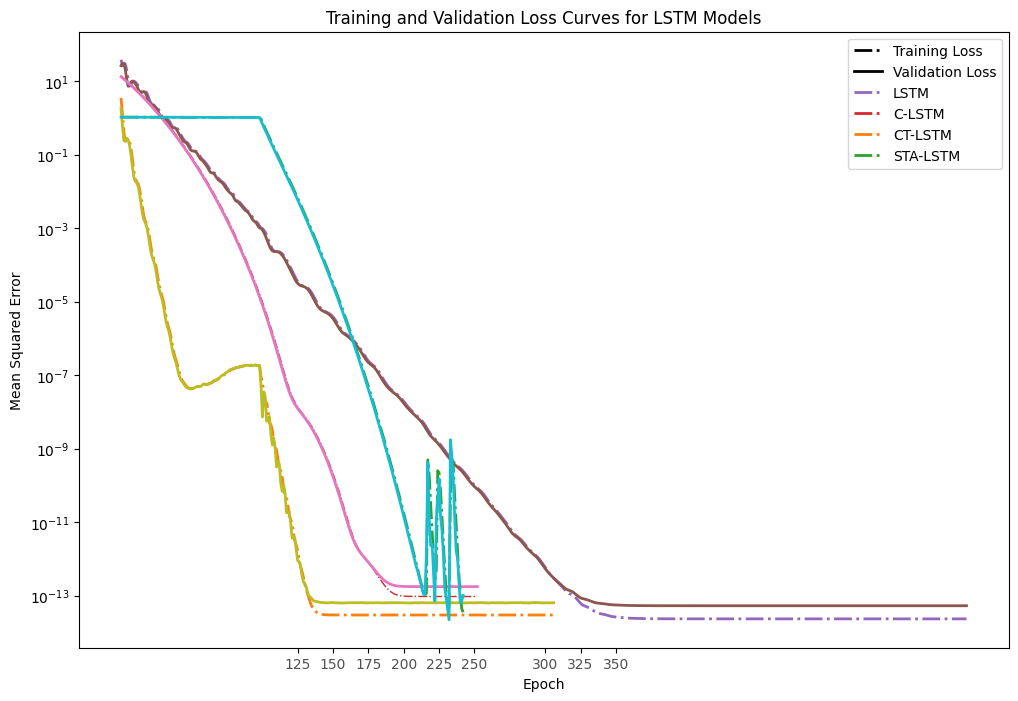

In [7]:
network1 = pd.read_csv('C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/training_data/lstm_50_loss_data.csv')
network2 = pd.read_csv('C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/training_data/c_50_loss_data.csv')
network3 = pd.read_csv('C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/training_data/ct_50_loss_data.csv')
network4 = pd.read_csv('C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/training_data/sta_50_loss_data.csv')

train_loss1 = network1['Training Loss']
val_loss1 = network1['Validation Loss']
train_loss2 = network2['Training Loss']
val_loss2 = network2['Validation Loss']
train_loss3 = network3['Training Loss']
val_loss3 = network3['Validation Loss']
train_loss4 = network4['Training Loss']
val_loss4 = network4['Validation Loss']

# Define the high-contrast colors
train_colors = ['#9467bd', '#d62728', '#ff7f0e', '#2ca02c']  # Purple, Red, Yellow, Green
val_colors = ['#8c564b', '#e377c2', '#bcbd22', '#17becf']    # Matching contrast colors

# Plot the data
plt.figure(figsize=(12, 8))

# Plot network 1
plt.plot(train_loss1, label='LSTM - Train Loss', color=train_colors[0], linestyle='-.', linewidth=2)
plt.plot(val_loss1, label='LSTM - Validation Loss', color=val_colors[0], linewidth=2)

# Plot network 2
plt.plot(train_loss2, label='C-LSTM - Train Loss', color=train_colors[1], linestyle='-.', linewidth=1)
plt.plot(val_loss2, label='C-LSTM - Validation Loss', color=val_colors[1], linewidth=2)

# Plot network 3
plt.plot(train_loss3, label='CT-LSTM - Train Loss', color=train_colors[2], linestyle='-.', linewidth=2)
plt.plot(val_loss3, label='CT-LSTM - Validation Loss', color=val_colors[2], linewidth=2)

# Plot network 4
plt.plot(train_loss4, label='STA-LSTM - Train Loss', color=train_colors[3], linestyle='-.', linewidth=2)
plt.plot(val_loss4, label='STA-LSTM - Validation Loss', color=val_colors[3], linewidth=2)

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.title('Training and Validation Loss Curves for LSTM Models')

# Custom legend
custom_lines = [
    plt.Line2D([0], [0], color='black', linestyle='-.', linewidth=2, label='Training Loss'),
    plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Validation Loss'),
    plt.Line2D([0], [0], color=train_colors[0], linestyle='-.', linewidth=2, label='LSTM'),
    plt.Line2D([0], [0], color=train_colors[1], linestyle='-.', linewidth=2, label='C-LSTM'),
    plt.Line2D([0], [0], color=train_colors[2], linestyle='-.', linewidth=2, label='CT-LSTM'),
    plt.Line2D([0], [0], color=train_colors[3], linestyle='-.', linewidth=2, label='STA-LSTM')
]

plt.legend(handles=custom_lines, loc='upper right')

# Adjust xticks
xticks = list(range(125, 251, 25)) + list(range(300, 351, 25))
plt.xticks(xticks)

# Adjust xticks color slightly
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_color('#505050')  # A grey color for the ticks

plt.show()
